<a href="https://colab.research.google.com/github/1dhiman/100days-ml/blob/master/2019/1_Unsupervised_Learning_end_to_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''Main'''
import numpy as np
import pandas as pd
import os

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep'''
from sklearn import preprocessing as pp 
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss 
from sklearn.metrics import precision_recall_curve, average_precision_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report 

'''Algos'''
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

## Data Preparation

In [3]:
file = "https://media.githubusercontent.com/media/aapatel09/handson-unsupervised-learning/master/datasets/credit_card_data/credit_card.csv"
data = pd.read_csv(file)

data.shape

(284807, 31)

## EDA

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [7]:
print(f"Number of fraudulent transactions: {data['Class'].sum()}")

Number of fraudulent transactions: 492


In [8]:
nanCounter = np.isnan(data).sum()
nanCounter

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [9]:
distinctCounter = data.apply(lambda x: len(x.unique()))
distinctCounter

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

## Generate feature matrix and labels array

In [0]:
dataX = data.copy().drop(['Class'],axis=1)
dataY = data['Class'].copy()

### Feature scaling

In [11]:
featuresToScale = dataX.drop(['Time'],axis=1).columns
featuresToScale

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [12]:
sX = pp.StandardScaler(copy=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
scalingFactors = pd.DataFrame(data=[sX.mean_,sX.scale_],index=['Mean','StDev'],columns=featuresToScale)

scalingFactors

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Mean,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,2.239751e-15,1.673327e-15,-1.254995e-15,8.176030e-16,1.206296e-15,4.913003e-15,1.437666e-15,-3.800113e-16,9.572133e-16,1.039817e-15,6.406703e-16,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619
StDev,1.958692e+00,1.651306e+00,1.516252e+00,1.415866e+00,1.380244e+00,1.332269e+00,1.237091e+00,1.194351e+00,1.098630e+00,1.088848e+00,1.020711e+00,9.991996e-01,9.952725e-01,9.585939e-01,9.153144e-01,8.762513e-01,8.493356e-01,8.381747e-01,8.140391e-01,7.709237e-01,7.345227e-01,7.257003e-01,6.244592e-01,6.056460e-01,5.212772e-01,4.822262e-01,4.036318e-01,3.300827e-01,250.119670


In [13]:
dataX.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,94813.859575,-8.157366e-16,3.154853e-17,-4.409878e-15,-6.734811e-16,-2.874435e-16,4.168992e-16,-8.767997e-16,-2.423604e-16,3.078727e-16,2.026926e-17,1.622758e-15,2.052953e-15,-8.310622e-17,-8.845502e-16,-1.789241e-15,-1.542079e-16,8.046919e-16,-2.547965e-16,-4.550555e-16,2.754870e-16,1.685077e-17,1.478472e-15,-6.797197e-16,1.234659e-16,-7.659279e-16,3.247603e-16,-2.953495e-18,5.401572e-17,3.202236e-16
std,47488.145955,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,0.000000,-2.879855e+01,-4.403529e+01,-3.187173e+01,-4.013919e+00,-8.240810e+01,-1.963606e+01,-3.520940e+01,-6.130252e+01,-1.222802e+01,-2.258191e+01,-4.700128e+00,-1.869868e+01,-5.819392e+00,-2.004428e+01,-4.915191e+00,-1.612534e+01,-2.962645e+01,-1.133266e+01,-8.861402e+00,-7.069146e+01,-4.741907e+01,-1.506565e+01,-7.175446e+01,-4.683638e+00,-1.975033e+01,-5.401098e+00,-5.590660e+01,-4.674612e+01,-3.532294e-01
25%,54201.500000,-4.698918e-01,-3.624707e-01,-5.872142e-01,-5.993788e-01,-5.010686e-01,-5.766822e-01,-4.478860e-01,-1.746805e-01,-5.853631e-01,-4.917360e-01,-7.470224e-01,-4.058964e-01,-6.516198e-01,-4.439565e-01,-6.368132e-01,-5.341353e-01,-5.695609e-01,-5.951621e-01,-5.605369e-01,-2.746334e-01,-3.109433e-01,-7.473476e-01,-2.591784e-01,-5.854676e-01,-6.084001e-01,-6.780717e-01,-1.755053e-01,-1.604440e-01,-3.308401e-01
50%,84692.000000,9.245351e-03,3.965683e-02,1.186124e-01,-1.401724e-02,-3.936682e-02,-2.058046e-01,3.241723e-02,1.871982e-02,-4.681169e-02,-8.533551e-02,-3.209268e-02,1.401448e-01,-1.363250e-02,5.278702e-02,5.251917e-02,7.579255e-02,-7.732604e-02,-4.338370e-03,4.588014e-03,-8.104705e-02,-4.009429e-02,9.345377e-03,-1.792420e-02,6.765678e-02,3.183240e-02,-1.081217e-01,3.325174e-03,3.406368e-02,-2.652715e-01
75%,139320.500000,6.716939e-01,4.867202e-01,6.774569e-01,5.250082e-01,4.433465e-01,2.991625e-01,4.611107e-01,2.740785e-01,5.435305e-01,4.168842e-01,7.245863e-01,6.187332e-01,6.656518e-01,5.144513e-01,7.088502e-01,5.971989e-01,4.705737e-01,5.974968e-01,5.637928e-01,1.725733e-01,2.537392e-01,7.283360e-01,2.364319e-01,7.257153e-01,6.728006e-01,4.996663e-01,2.255648e-01,2.371526e-01,-4.471707e-02
max,172792.000000,1.253351e+00,1.335775e+01,6.187993e+00,1.191874e+01,2.521413e+01,5.502015e+01,9.747824e+01,1.675153e+01,1.419494e+01,2.180758e+01,1.177504e+01,7.854679e+00,7.160735e+00,1.098147e+01,9.699117e+00,1.976044e+01,1.089502e+01,6.014342e+00,6.869414e+00,5.113464e+01,3.703471e+01,1.447304e+01,3.607668e+01,7.569684e+00,1.442532e+01,7.293975e+00,7.831940e+01,1.025434e+02,1.023622e+02


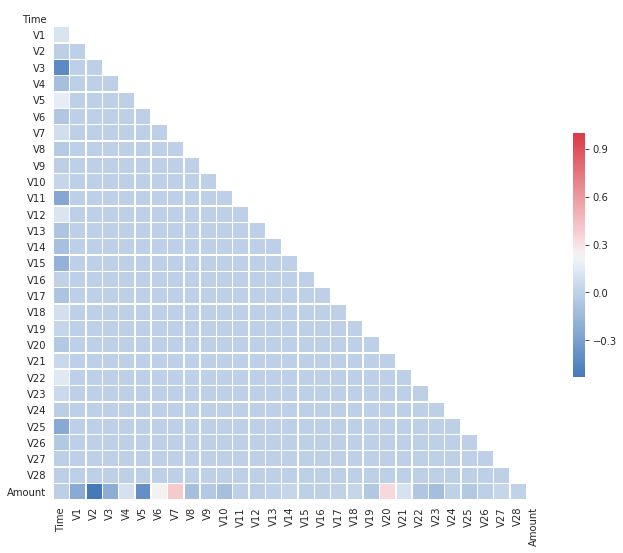

In [25]:
def CorrMtx(df, dropDuplicates = True):

    # Your dataset is already a correlation matrix.
    # If you have a dateset where you need to include the calculation
    # of a correlation matrix, just uncomment the line below:
    # df = df.corr()

    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)


CorrMtx(dataX.corr(), dropDuplicates = True)

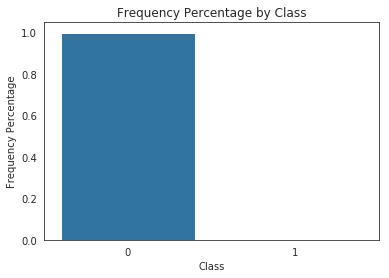

In [22]:
count_classes = pd.value_counts(data['Class'],sort=True).sort_index()
ax = sns.barplot(x=count_classes.index, y=tuple(count_classes/len(data)))
ax.set_title('Frequency Percentage by Class')
ax.set_xlabel('Class')
ax.set_ylabel('Frequency Percentage');

## Model preparation

In [0]:
X_train, X_test, y_train, y_test = train_test_split(dataX, 
                                    dataY, test_size=0.33, 
                                    random_state=2018, stratify=dataY)

In [30]:
print(f"{len(X_train)}, {len(X_test)}")

print(f"{y_train.sum()/len(y_train)}, {y_test.sum()/len(y_test)}")

190820, 93987
0.0017293784718582959, 0.0017236426314277506


In [0]:
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2019)

### Logistic Regression

In [0]:
penalty = 'l2'
C = 1.0
class_weight = 'balanced'
random_state = 2018
solver = 'liblinear'
n_jobs = 1

logReg = LogisticRegression(penalty=penalty, C=C, 
            class_weight=class_weight, random_state=random_state, 
                            solver=solver, n_jobs=n_jobs)

In [47]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                        index=y_train.index,columns=[0,1])

model = logReg

for train_index, cv_index in k_fold.split(np.zeros(len(X_train))
                                          ,y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    model.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold, 
                               model.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = \
        model.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, 
                         predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: \t', loglossTraining)
    print('CV Log Loss: \t\t', loglossCV)
    
loglossLogisticRegression = log_loss(y_train, 
                                     predictionsBasedOnKFolds.loc[:,1])
print('\nLogistic Regression Log Loss: ', loglossLogisticRegression)

Training Log Loss: 	 0.10872257454872745
CV Log Loss: 		 0.1121473743467259
Training Log Loss: 	 0.10497344310013944
CV Log Loss: 		 0.1015435294231754
Training Log Loss: 	 0.10651594119793548
CV Log Loss: 		 0.10845264863532371
Training Log Loss: 	 0.1083837119683358
CV Log Loss: 		 0.10783870394281046
Training Log Loss: 	 0.11740424340255655
CV Log Loss: 		 0.11652224289983165

Logistic Regression Log Loss:  0.10930089984957343


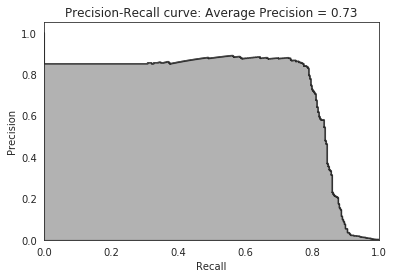

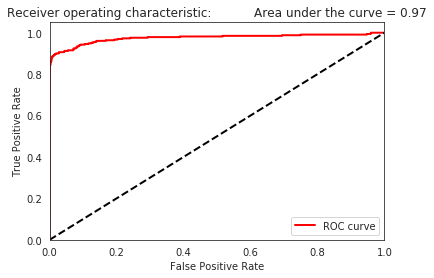

In [48]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsLogisticRegression = preds.copy()

precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],
                                                       preds['prediction'])

average_precision = average_precision_score(preds['trueLabel'],
                                            preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision));


fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])

areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
          Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

### Random forest classification

In [0]:
n_estimators = 10
max_features = 'auto'
max_depth = None
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0.0
max_leaf_nodes = None
bootstrap = True
oob_score = False
n_jobs = -1
random_state = 2019
class_weight = 'balanced'

RFC = RandomForestClassifier(n_estimators=n_estimators, 
        max_features=max_features, max_depth=max_depth,
        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
        min_weight_fraction_leaf=min_weight_fraction_leaf, 
        max_leaf_nodes=max_leaf_nodes, bootstrap=bootstrap, 
        oob_score=oob_score, n_jobs=n_jobs, random_state=random_state, 
        class_weight=class_weight)

In [50]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                        index=y_train.index,columns=[0,1])

model = RFC

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    model.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold, \
                                model.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = \
        model.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: \t', loglossTraining)
    print('CV Log Loss: \t\t', loglossCV)
    
loglossRandomForestsClassifier = log_loss(y_train, 
                                          predictionsBasedOnKFolds.loc[:,1])
print('\nRandom Forests Log Loss: ', loglossRandomForestsClassifier)

Training Log Loss: 	 0.00039715126116658683
CV Log Loss: 		 0.013537742562508956
Training Log Loss: 	 0.00047411697020335246
CV Log Loss: 		 0.010742404971077686
Training Log Loss: 	 0.0003880509897084398
CV Log Loss: 		 0.01261337080190984
Training Log Loss: 	 0.00043244328431786875
CV Log Loss: 		 0.008303376869785401
Training Log Loss: 	 0.0004518111720306605
CV Log Loss: 		 0.010846053115868814

Random Forests Log Loss:  0.011208589664230138


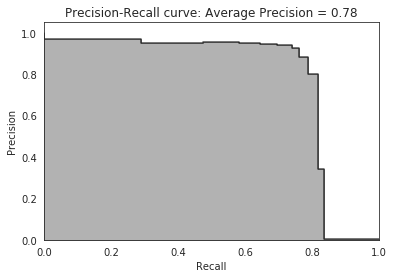

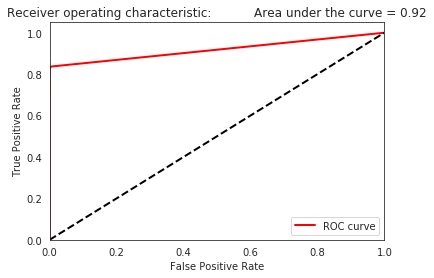

In [51]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsRandomForests = preds.copy()

precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],
                                                       preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],
                                            preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
          Area under the curve = {0:0.2f}'.format(
          areaUnderROC))
plt.legend(loc="lower right")
plt.show()

### XGB

In [0]:
params_xGB = {
    'nthread':16, #number of cores
    'learning rate': 0.3, #range 0 to 1, default 0.3
    'gamma': 0, #range 0 to infinity, default 0 
        # increase to reduce complexity (increase bias, reduce variance)
    'max_depth': 6, #range 1 to infinity, default 6
    'min_child_weight': 1, #range 0 to infinity, default 1
    'max_delta_step': 0, #range 0 to infinity, default 0
    'subsample': 1.0, #range 0 to 1, default 1
        # subsample ratio of the training examples
    'colsample_bytree': 1.0, #range 0 to 1, default 1 
        # subsample ratio of features
    'objective':'binary:logistic',
    'num_class':1,
    'eval_metric':'logloss',
    'seed':2019,
    'silent':0
}

In [55]:
%%time 

trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                    index=y_train.index,columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    dtrain = xgb.DMatrix(data=X_train_fold, label=y_train_fold)
    dCV = xgb.DMatrix(data=X_cv_fold)
    
    bst = xgb.cv(params_xGB, dtrain, num_boost_round=2000, 
                 nfold=5, early_stopping_rounds=200, verbose_eval=50)
    
    best_rounds = np.argmin(bst['test-logloss-mean'])
    bst = xgb.train(params_xGB, dtrain, best_rounds)
    
    loglossTraining = log_loss(y_train_fold, bst.predict(dtrain))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        bst.predict(dCV)
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: \t', loglossTraining)
    print('CV Log Loss: \t\t', loglossCV)
    
loglossXGBoostGradientBoosting = \
    log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print('\nXGBoost Gradient Boosting Log Loss: ', loglossXGBoostGradientBoosting)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.437914+5.4364e-05	test-logloss:0.438031+3.63208e-05
[50]	train-logloss:0.000132+1.01784e-05	test-logloss:0.0030856+0.000235155
[100]	train-logloss:5.48e-05+2.22711e-06	test-logloss:0.0033776+0.000284274
[150]	train-logloss:4.08e-05+1.72047e-06	test-logloss:0.0034652+0.000320237
[200]	train-logloss:3.48e-05+1.16619e-06	test-logloss:0.0035236+0.000336996


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Training Log Loss: 	 0.0007628954189198954
CV Log Loss: 		 0.003161261443199985


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.43794+5.41605e-05	test-logloss:0.438089+3.96858e-05
[50]	train-logloss:0.0001442+1.19733e-05	test-logloss:0.0033742+0.000568714
[100]	train-logloss:5.78e-05+2.22711e-06	test-logloss:0.0036288+0.000608461
[150]	train-logloss:4.24e-05+1.35647e-06	test-logloss:0.003746+0.000639809
[200]	train-logloss:3.64e-05+8e-07	test-logloss:0.0037912+0.000656205


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Training Log Loss: 	 0.0009803207000435726
CV Log Loss: 		 0.002736133000253262


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.437906+5.5344e-05	test-logloss:0.438037+0.000105672
[50]	train-logloss:0.0001346+1.48674e-05	test-logloss:0.0030614+0.00101256
[100]	train-logloss:5.54e-05+3.49857e-06	test-logloss:0.0032954+0.00109517
[150]	train-logloss:4.14e-05+2.41661e-06	test-logloss:0.0033832+0.00111693
[200]	train-logloss:3.52e-05+1.72047e-06	test-logloss:0.0034312+0.00113317


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Training Log Loss: 	 0.0006862201506408196
CV Log Loss: 		 0.003285560899609145


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.437947+5.92824e-05	test-logloss:0.438076+3.79663e-05
[50]	train-logloss:0.0001442+5.9127e-06	test-logloss:0.0032006+0.000176953
[100]	train-logloss:5.84e-05+1.0198e-06	test-logloss:0.0034624+0.000193438
[150]	train-logloss:4.3e-05+8.94427e-07	test-logloss:0.0035526+0.000199342
[200]	train-logloss:3.66e-05+4.89898e-07	test-logloss:0.003619+0.000188412


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Training Log Loss: 	 0.0005990604496836869
CV Log Loss: 		 0.0028157123895389672


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.437976+6.08704e-05	test-logloss:0.438083+6.6922e-05
[50]	train-logloss:0.0001438+9.98799e-06	test-logloss:0.0034248+0.00111598
[100]	train-logloss:5.9e-05+3.57771e-06	test-logloss:0.0037086+0.0012653
[150]	train-logloss:4.32e-05+2.31517e-06	test-logloss:0.0038072+0.00131186
[200]	train-logloss:3.64e-05+1.49666e-06	test-logloss:0.0038718+0.00133784


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Training Log Loss: 	 0.000877743423368777
CV Log Loss: 		 0.0024479567689590295

XGBoost Gradient Boosting Log Loss:  0.0028893249003120775
CPU times: user 50min 29s, sys: 19 s, total: 50min 48s
Wall time: 26min 10s


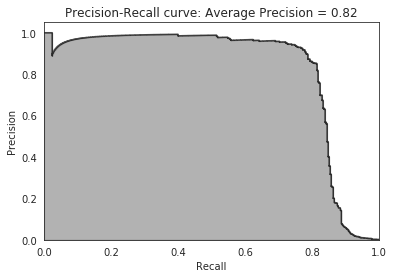

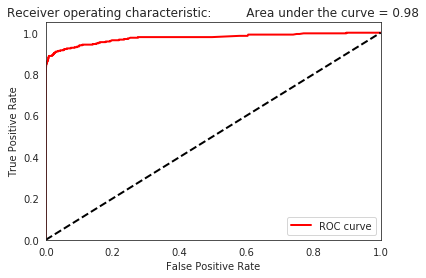

In [56]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,'prediction']], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsXGBoostGradientBoosting = preds.copy()

precision, recall, thresholds = \
    precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = \
    average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
        Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

### Light GBM

In [0]:
params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':16
}

In [60]:
%%time

trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                index=y_train.index,columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], \
        X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, \
                gbm.predict(X_train_fold, num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: \t', loglossTraining)
    print('CV Log Loss: \t\t', loglossCV)
    
loglossLightGBMGradientBoosting = \
    log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print('\nLightGBM Gradient Boosting Log Loss: ', loglossLightGBMGradientBoosting)

[289]	valid_0's binary_logloss: 0.00312872
[290]	valid_0's binary_logloss: 0.00312142
[291]	valid_0's binary_logloss: 0.00312031
[292]	valid_0's binary_logloss: 0.00311803
[293]	valid_0's binary_logloss: 0.00311609
[294]	valid_0's binary_logloss: 0.00311491
[295]	valid_0's binary_logloss: 0.00311056
[296]	valid_0's binary_logloss: 0.00310938
[297]	valid_0's binary_logloss: 0.00310689
[298]	valid_0's binary_logloss: 0.00310509
[299]	valid_0's binary_logloss: 0.0031047
[300]	valid_0's binary_logloss: 0.00310296
[301]	valid_0's binary_logloss: 0.00310261
[302]	valid_0's binary_logloss: 0.00310014
[303]	valid_0's binary_logloss: 0.00309901
[304]	valid_0's binary_logloss: 0.00309735
[305]	valid_0's binary_logloss: 0.00309625
[306]	valid_0's binary_logloss: 0.00309481
[307]	valid_0's binary_logloss: 0.00309417
[308]	valid_0's binary_logloss: 0.00309243
[309]	valid_0's binary_logloss: 0.00309151
[310]	valid_0's binary_logloss: 0.00309069
[311]	valid_0's binary_logloss: 0.00309034
[312]	valid_

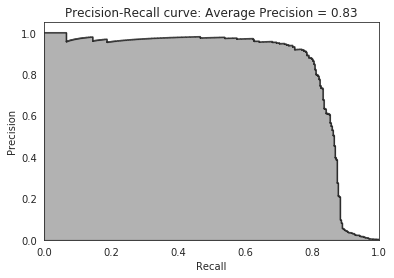

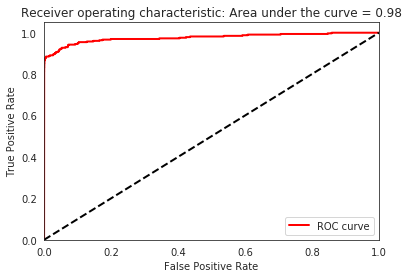

In [61]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,'prediction']], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsLightGBMGradientBoosting = preds.copy()

precision, recall, thresholds = \
    precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = \
    average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

## Test set evaluation

In [62]:
predictionsTestSetLogisticRegression = \
    pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
predictionsTestSetLogisticRegression.loc[:,'prediction'] = \
    logReg.predict_proba(X_test)[:,1]
logLossTestSetLogisticRegression = \
    log_loss(y_test, predictionsTestSetLogisticRegression)

predictionsTestSetRandomForests = \
    pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
predictionsTestSetRandomForests.loc[:,'prediction'] = \
    RFC.predict_proba(X_test)[:,1]
logLossTestSetRandomForests = \
    log_loss(y_test, predictionsTestSetRandomForests)

predictionsTestSetXGBoostGradientBoosting = \
    pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
dtest = xgb.DMatrix(data=X_test)
predictionsTestSetXGBoostGradientBoosting.loc[:,'prediction'] = \
    bst.predict(dtest)
logLossTestSetXGBoostGradientBoosting = \
    log_loss(y_test, predictionsTestSetXGBoostGradientBoosting)

predictionsTestSetLightGBMGradientBoosting = \
    pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
predictionsTestSetLightGBMGradientBoosting.loc[:,'prediction'] = \
    gbm.predict(X_test, num_iteration=gbm.best_iteration)
logLossTestSetLightGBMGradientBoosting = \
    log_loss(y_test, predictionsTestSetLightGBMGradientBoosting)

print("Log Loss of Logistic Regression on Test Set: ", \
          logLossTestSetLogisticRegression)
print("Log Loss of Random Forests on Test Set: ", \
          logLossTestSetRandomForests)
print("Log Loss of XGBoost Gradient Boosting on Test Set: ", \
          logLossTestSetXGBoostGradientBoosting)
print("Log Loss of LightGBM Gradient Boosting on Test Set: ", \
          logLossTestSetLightGBMGradientBoosting)

Log Loss of Logistic Regression on Test Set:  0.11776795913593349
Log Loss of Random Forests on Test Set:  0.009401577175116227
Log Loss of XGBoost Gradient Boosting on Test Set:  0.002466704245321727
Log Loss of LightGBM Gradient Boosting on Test Set:  0.0025431909868812016


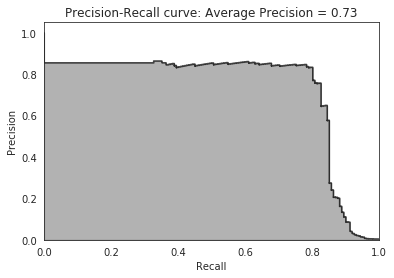

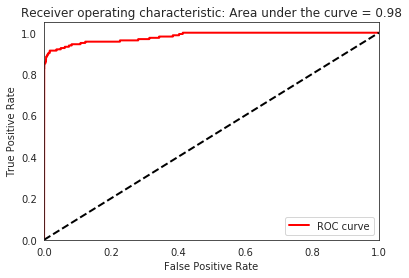

In [63]:
precision, recall, thresholds = \
    precision_recall_curve(y_test,predictionsTestSetLogisticRegression)
average_precision = \
    average_precision_score(y_test,predictionsTestSetLogisticRegression)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(y_test,predictionsTestSetLogisticRegression)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

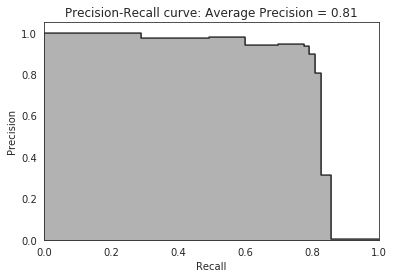

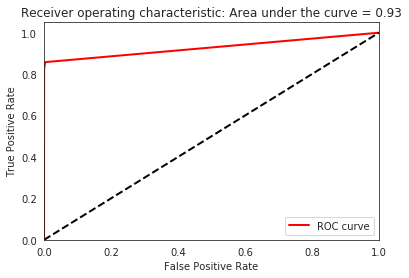

In [64]:
precision, recall, thresholds = \
    precision_recall_curve(y_test,predictionsTestSetRandomForests)
average_precision = \
    average_precision_score(y_test,predictionsTestSetRandomForests)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(y_test,predictionsTestSetRandomForests)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

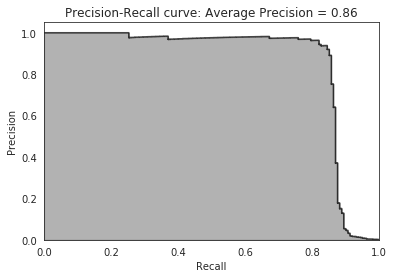

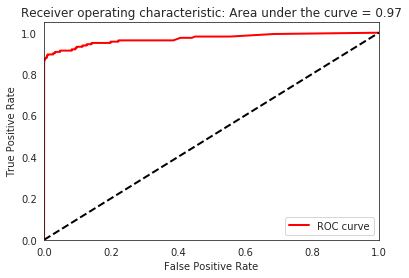

In [65]:
precision, recall, thresholds = \
    precision_recall_curve(y_test,predictionsTestSetXGBoostGradientBoosting)
average_precision = \
    average_precision_score(y_test,predictionsTestSetXGBoostGradientBoosting)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = \
    roc_curve(y_test,predictionsTestSetXGBoostGradientBoosting)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

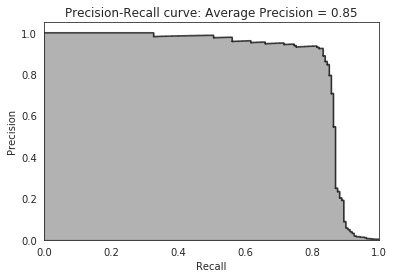

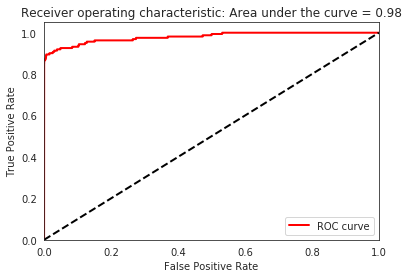

In [66]:
precision, recall, thresholds = \
    precision_recall_curve(y_test,predictionsTestSetLightGBMGradientBoosting)
average_precision = \
    average_precision_score(y_test,predictionsTestSetLightGBMGradientBoosting)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = \
    roc_curve(y_test,predictionsTestSetLightGBMGradientBoosting)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

### Ensemble

In [0]:
predictionsBasedOnKFoldsFourModels = pd.DataFrame(data=[],index=y_train.index)
predictionsBasedOnKFoldsFourModels = predictionsBasedOnKFoldsFourModels.join(
    predictionsBasedOnKFoldsLogisticRegression['prediction'].astype(float), \
    how='left').join(predictionsBasedOnKFoldsRandomForests['prediction'] \
    .astype(float),how='left',rsuffix="2").join( \
    predictionsBasedOnKFoldsXGBoostGradientBoosting['prediction'].astype(float), \
    how='left',rsuffix="3").join( \
    predictionsBasedOnKFoldsLightGBMGradientBoosting['prediction'].astype(float), \
    how='left',rsuffix="4")
predictionsBasedOnKFoldsFourModels.columns = \
    ['predsLR','predsRF','predsXGB','predsLightGBM']

In [0]:
X_trainWithPredictions = \
    X_train.merge(predictionsBasedOnKFoldsFourModels,
                  left_index=True,right_index=True)

In [0]:
params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':16
}

In [70]:
trainingScores = []
cvScores = []
predictionsBasedOnKFoldsEnsemble = \
    pd.DataFrame(data=[],index=y_train.index,columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)), \
                                          y_train.ravel()):
    X_train_fold, X_cv_fold = \
        X_trainWithPredictions.iloc[train_index,:], \
        X_trainWithPredictions.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, \
        gbm.predict(X_train_fold, num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFoldsEnsemble.loc[X_cv_fold.index,'prediction'] = \
        gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFoldsEnsemble.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossEnsemble = log_loss(y_train, \
        predictionsBasedOnKFoldsEnsemble.loc[:,'prediction'])
print('Ensemble Log Loss: ', loglossEnsemble)

[597]	valid_0's binary_logloss: 0.00222463
[598]	valid_0's binary_logloss: 0.00222548
[599]	valid_0's binary_logloss: 0.00222554
[600]	valid_0's binary_logloss: 0.00222561
[601]	valid_0's binary_logloss: 0.00222528
[602]	valid_0's binary_logloss: 0.0022248
[603]	valid_0's binary_logloss: 0.00222507
[604]	valid_0's binary_logloss: 0.00222452
[605]	valid_0's binary_logloss: 0.00222438
[606]	valid_0's binary_logloss: 0.00222443
[607]	valid_0's binary_logloss: 0.00222453
[608]	valid_0's binary_logloss: 0.00222444
[609]	valid_0's binary_logloss: 0.00222446
[610]	valid_0's binary_logloss: 0.00222448
[611]	valid_0's binary_logloss: 0.00222434
[612]	valid_0's binary_logloss: 0.00222443
[613]	valid_0's binary_logloss: 0.00222426
[614]	valid_0's binary_logloss: 0.00222409
[615]	valid_0's binary_logloss: 0.00222407
[616]	valid_0's binary_logloss: 0.00222493
[617]	valid_0's binary_logloss: 0.00222479
[618]	valid_0's binary_logloss: 0.00222421
[619]	valid_0's binary_logloss: 0.0022242
[620]	valid_0

In [71]:
print('Feature importances:', list(gbm.feature_importance()))

Feature importances: [310, 280, 219, 392, 355, 142, 231, 275, 113, 124, 273, 122, 400, 264, 504, 208, 283, 137, 204, 260, 168, 185, 155, 311, 184, 300, 431, 194, 109, 634, 555, 114, 420, 370]


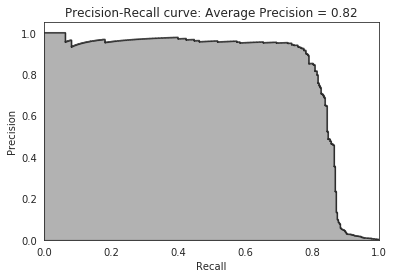

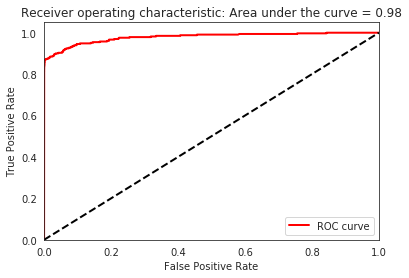

In [72]:
preds = pd.concat([y_train,predictionsBasedOnKFoldsEnsemble.loc[:,'prediction']], axis=1)
preds.columns = ['trueLabel','prediction']

precision, recall, thresholds = \
    precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = \
    average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

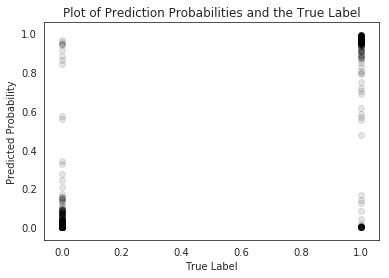

In [73]:
scatterData = predictionsTestSetLightGBMGradientBoosting.join(y_test,how='left')
scatterData.columns = ['Predicted Probability','True Label']
ax = sns.regplot(x="True Label", y="Predicted Probability", color='k', 
                 fit_reg=False, scatter_kws={'alpha':0.1},
                 data=scatterData).set_title( \
                'Plot of Prediction Probabilities and the True Label')

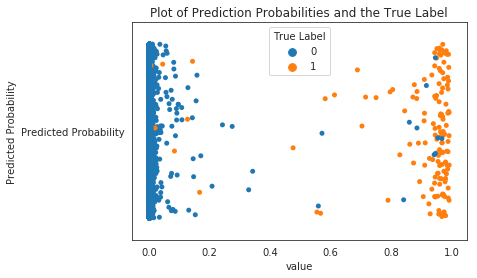

In [74]:
scatterDataMelted = pd.melt(scatterData, "True Label", \
                            var_name="Predicted Probability")
ax = sns.stripplot(x="value", y="Predicted Probability", \
                   hue='True Label', jitter=0.4, \
                   data=scatterDataMelted).set_title( \
                   'Plot of Prediction Probabilities and the True Label')

In [75]:
'''Pipeline for New Data'''
# first, import new data into a dataframe called 'newData'
# second, scale data
# newData.loc[:,featuresToScale] = sX.transform(newData[featuresToScale])
# third, predict using LightGBM
# gbm.predict(newData, num_iteration=gbm.best_iteration)

'Pipeline for New Data'